In [86]:
!uv add torch torchvision matplotlib

Resolved 69 packages in 0.90ms
Audited 38 packages in 0.44ms


In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Check if the current `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# is available, and if not, use the CPU
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### Datasets

Train: 60000  |  Test: 10000
torch.Size([1, 28, 28])


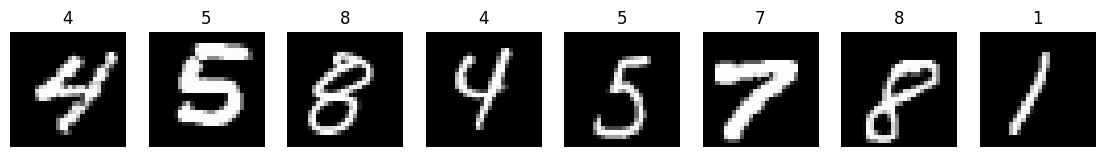

In [88]:
# from torch.utils.data import DataLoader
# # Chargement du dataset MINST
batch_size = 128
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(2/28, 2/28)),
    transforms.ToTensor()
])
test_transform  = transforms.Compose([transforms.ToTensor()])
train_MNIST = datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
test_MNIST = datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)


trainloader_MNIST = DataLoader(train_MNIST, batch_size=batch_size, shuffle=True)
testloader_MNIST  = DataLoader(test_MNIST, batch_size=batch_size, shuffle=False)

# # # Vérification
print(f"Train: {len(train_MNIST)}  |  Test: {len(test_MNIST)}")

# # # Affichage d’un batch du train set
images_MNIST, labels_MNIST = next(iter(trainloader_MNIST))

fig, axs = plt.subplots(1, 8, figsize=(14, 2))
print(images_MNIST[0].size())
for i in range(8):
    axs[i].imshow(images_MNIST[i][0], cmap='gray')  # select channel 0
    axs[i].set_title(str(labels_MNIST[i].item()))
    axs[i].axis('off')

plt.show()




In [89]:
# Below we are preprocessing data for CIFAR-100. We use an arbitrary batch size of 128.
CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD  = (0.2675, 0.2565, 0.2761)

train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])
test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])

# Loading the CIFAR-100 dataset:
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_tf)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_tf)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

dataset_name = "CIFAR100"

Number of training samples: 50000
Number of test samples: 10000


In [90]:
#Dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Train/Eval

In [91]:
from torch.nn import Module

def apply_max_norm(model, r=3.0):
    with torch.no_grad():
        for name, p in model.named_parameters():
            # Only Linear weights: [out_features, in_features]
            if 'weight' in name and p.dim() == 2:
                norms = p.norm(2, dim=1, keepdim=True)          # per-unit (row) L2
                desired = torch.clamp(norms, max=r)
                p.mul_(desired / (1e-8 + norms))

def train_epoch(model: Module, loader: DataLoader, learning_rate: float, device, regularization: float = 0.0):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    running_loss = 0.0
    training_acc = 0
    total = 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        if regularization > 0.0:
            apply_max_norm(model, r=regularization)

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        training_acc += (predicted == y).sum().item()

        

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * training_acc / total
    print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%')
    return epoch_loss, epoch_acc




In [99]:
def evaluate(model: Module, loader: DataLoader, device):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    running_loss = 0.0
    correct = 0
    errors = np.zeros(10, dtype=int)
    total = 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            outputs = model(x)

            _, preds = torch.max(outputs.data, dim=1)


            loss = criterion(outputs, y)
            running_loss += loss.item()
            correct += (preds == y).sum().item()
            wrong_mask = preds.cpu().numpy() != y.cpu().numpy()

            # Count how many times each true label was misclassified
            np.add.at(errors, y.cpu().numpy()[wrong_mask], 1)
            total += y.size(0)

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Test Errors: {errors}, Total: {errors.sum()}")
    return accuracy, errors

# MLP (Reproduction of Distilling the Knowledge in a Neural Network by Hinton et al.)

In [93]:
class TeacherMLP(nn.Module):
    def __init__(self):
        super(TeacherMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 1200),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1200, 1200),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1200, 10)
        )

    def forward(self, x):
        x = self.layers(x)
        return x
    
class StudentMLP(nn.Module):
    def __init__(self):
        super(StudentMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 800),
            nn.ReLU(),
            nn.Linear(800, 800),
            nn.ReLU(),
            nn.Linear(800, 10)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [ ]:
torch.manual_seed(42)
mlp_teacher = TeacherMLP().to(device)
teacher_mlp_loss_history = []
teacher_mlp_accuracy_history = []

for epoch in range(10):
    print(f"Epoch {epoch + 1}")
    loss, acc = train_epoch(mlp_teacher, trainloader_MNIST, learning_rate=0.001, device=device, regularization=3.0)
    teacher_mlp_loss_history.append(loss)
    teacher_mlp_accuracy_history.append(acc)

evaluate(mlp_teacher, testloader_MNIST, device)

Epoch 1
Training Loss: 0.4342, Training Accuracy: 86.52%
Epoch 2
Training Loss: 0.2126, Training Accuracy: 93.50%
Epoch 3
Training Loss: 0.1775, Training Accuracy: 94.61%
Epoch 4
Training Loss: 0.1601, Training Accuracy: 95.23%
Epoch 5
Training Loss: 0.1516, Training Accuracy: 95.51%
Epoch 6
Training Loss: 0.1458, Training Accuracy: 95.65%
Epoch 7


In [ ]:
torch.manual_seed(42)
mlp_student = StudentMLP().to(device)
torch.manual_seed(42)
mlp_student_kd = StudentMLP().to(device)
student_mlp_loss_history = []
student_mlp_accuracy_history = []

for epoch in range(10):
    print(f"Epoch {epoch + 1}")
    loss, acc = train_epoch(mlp_student, trainloader_MNIST, learning_rate=0.001, device=device, regularization=3.0)
    student_mlp_loss_history.append(loss)
    student_mlp_accuracy_history.append(acc)

evaluate(mlp_student, testloader_MNIST, device)

Epoch 1
Training Loss: 0.3548, Training Accuracy: 88.96%


NameError: name 'np' is not defined

In [ ]:
import matplotlib.pyplot as plt

# --- FIGURE 1 : Train Loss - MLP vs CNN ---
print
plt.figure(figsize=(6,4))
plt.plot(teacher_mlp_loss_history, label='Teacher')
plt.plot(student_mlp_loss_history, label='Student')
plt.title('Train Loss - Teacher vs Student')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# CNN 

### Teacher

In [ ]:
class TeacherNN(nn.Module):
    def __init__(self, num_classes=10):
        super(TeacherNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
from pathlib import Path
torch.manual_seed(42)
nn_teacher = TeacherNN(num_classes=100).to(device)
teacher_loss_history = []
teacher_accuracy_history = []
#If model exists, load weights else train
if Path(f'./model/CIFAR100/teacher_model_{dataset_name}.pth').exists():
    nn_teacher.load_state_dict(torch.load(f'./model/CIFAR100/teacher_model_{dataset_name}.pth'))
    print("Loaded pre-trained teacher model.")
else:
    for epoch in range(100):
        print(f"Epoch {epoch + 1}")
        loss, acc = train_epoch(nn_teacher, train_loader, learning_rate=0.001, device=device)
        teacher_loss_history.append(loss)
        teacher_accuracy_history.append(acc)

        #Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save(nn_teacher.state_dict(), f'./model/CIFAR100/teacher_model_{dataset_name}_epoch_{epoch + 1}.pth')
            evaluate(nn_teacher, test_loader, device)

test_accuracy_teacher = evaluate(nn_teacher, test_loader, device)

Epoch 1


Training Loss: 3.6907, Training Accuracy: 13.33%
Epoch 2
Training Loss: 2.9961, Training Accuracy: 25.13%
Epoch 3
Training Loss: 2.6336, Training Accuracy: 32.19%
Epoch 4
Training Loss: 2.4313, Training Accuracy: 36.40%
Epoch 5
Training Loss: 2.2999, Training Accuracy: 39.17%
Epoch 6
Training Loss: 2.1907, Training Accuracy: 41.51%
Epoch 7
Training Loss: 2.1067, Training Accuracy: 43.54%
Epoch 8
Training Loss: 2.0444, Training Accuracy: 44.93%
Epoch 9
Training Loss: 1.9860, Training Accuracy: 45.89%
Epoch 10
Training Loss: 1.9291, Training Accuracy: 47.40%
Test Accuracy: 49.34%
Epoch 11
Training Loss: 1.8911, Training Accuracy: 48.53%
Epoch 12
Training Loss: 1.8476, Training Accuracy: 49.21%
Epoch 13
Training Loss: 1.8032, Training Accuracy: 50.09%
Epoch 14
Training Loss: 1.7779, Training Accuracy: 50.80%
Epoch 15
Training Loss: 1.7610, Training Accuracy: 51.23%
Epoch 16
Training Loss: 1.7199, Training Accuracy: 51.93%
Epoch 17
Training Loss: 1.7018, Training Accuracy: 52.56%
Epoch 18


### Student

In [ ]:
class StudentNN(nn.Module):
    def __init__(self, num_classes=10):
        super(StudentNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
from pathlib import Path

torch.manual_seed(42)
nn_student = StudentNN(num_classes=100).to(device)
torch.manual_seed(42)
nn_student_distillation = StudentNN(num_classes=100).to(device)


# Print the norm of the first layer of the initial lightweight model
print("Norm of 1st layer of nn_student:", torch.norm(nn_student.features[0].weight).item())
# Print the norm of the first layer of the new lightweight model
print("Norm of 1st layer of nn_student_distillation:", torch.norm(nn_student_distillation.features[0].weight).item())

total_params_teacher = "{:,}".format(sum(p.numel() for p in nn_teacher.parameters()))
print(f"TeacherNN parameters: {total_params_teacher}")
total_params_student = "{:,}".format(sum(p.numel() for p in nn_student.parameters()))
print(f"StudentNN parameters: {total_params_student}")


student_loss_history = []
student_accuracy_history = []

#If model exists, load weights else train
if Path(f'./model/CIFAR100/student_model_{dataset_name}.pth').exists():
    nn_student.load_state_dict(torch.load(f'./model/CIFAR100/student_model_{dataset_name}.pth'))
    print("Loaded pre-trained student model.")
else:
    for epoch in range(10):
        print(f"Epoch {epoch + 1}")
        loss, acc = train_epoch(nn_student, train_loader, learning_rate=0.001, device=device)
        student_loss_history.append(loss)
        student_accuracy_history.append(acc)
        
        if (epoch + 1) % 10 == 0:
            torch.save(nn_student.state_dict(), f'./model/CIFAR100/student_model_{dataset_name}_epoch_{epoch + 1}.pth')

test_accuracy_student = evaluate(nn_student, test_loader, device)

Norm of 1st layer of nn_student: 2.327361822128296
Norm of 1st layer of nn_student_distillation: 2.327361822128296
TeacherNN parameters: 1,233,732
StudentNN parameters: 290,868
Epoch 1
Training Loss: 3.8976, Training Accuracy: 10.41%
Epoch 2
Training Loss: 3.3816, Training Accuracy: 18.64%
Epoch 3
Training Loss: 3.1981, Training Accuracy: 21.89%
Epoch 4
Training Loss: 3.0832, Training Accuracy: 24.03%
Epoch 5
Training Loss: 2.9981, Training Accuracy: 25.77%
Epoch 6
Training Loss: 2.9269, Training Accuracy: 27.14%
Epoch 7
Training Loss: 2.8684, Training Accuracy: 28.34%
Epoch 8
Training Loss: 2.8160, Training Accuracy: 29.26%
Epoch 9
Training Loss: 2.7703, Training Accuracy: 30.32%
Epoch 10
Training Loss: 2.7281, Training Accuracy: 31.28%
Test Accuracy: 34.73%


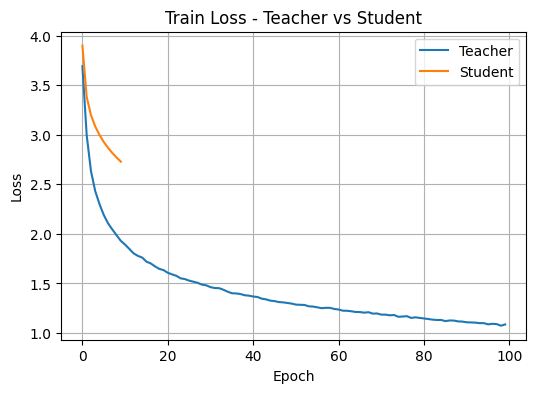

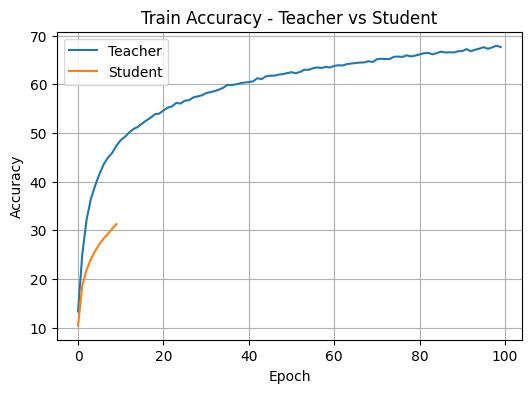

In [ ]:
import matplotlib.pyplot as plt

# --- FIGURE 1 : Train Loss - MLP vs CNN ---
print
plt.figure(figsize=(6,4))
plt.plot(teacher_loss_history, label='Teacher')
plt.plot(student_loss_history, label='Student')
plt.title('Train Loss - Teacher vs Student')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- FIGURE 2 : Test Accuracy - MLP vs CNN ---
plt.figure(figsize=(6,4))
plt.plot(teacher_accuracy_history, label='Teacher')
plt.plot(student_accuracy_history, label='Student')
plt.title('Train Accuracy - Teacher vs Student')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()